[View in Colaboratory](https://colab.research.google.com/github/iegorval/neural_nets/blob/master/Internship.ipynb)

# Getting Ready
Prepare the files and the libraries for the experiment.

In [1]:
# Installs
!pip install -U -q PyDrive

In [2]:
# Imports
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM, Input, Activation, Dense, TimeDistributed, Dropout, BatchNormalization
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import Callback
import keras.backend as K
import keras.utils as utils
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import re
from io import StringIO

Using TensorFlow backend.


In [3]:
# PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Get all files from the root folder
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()

In [4]:
# Get the .pow files 
pow_files = [(file['title'], file['id'], re.sub(r'_[0-9]+|.pow', '', file['title'])) 
             for file in file_list if file['title'].find('.pow')>0]
num_examples = len(pow_files)
# Get the categories
categories = list(set([file_info[2] for file_info in pow_files]))
# Get the dictionary of the categories
num_cat = len(categories)
categories_dict = {categories[i] : i for i in range(num_cat)}

In [0]:
print(categories_dict)

{'grass_rough': 0, 'grass_flat': 1, 'cubes': 2, 'flat': 3, 'black_flat': 4, 'black_rough': 5}


# Utils
Helper functions.

In [5]:
def to_one_hot(category):
  assert category < num_cat
  one_hot = np.zeros((num_cat))
  one_hot[category] = 1
  return one_hot

In [6]:
def from_one_hot(one_hot):
  for i in range(len(one_hot)):
    if one_hot[i]==1:
      return i

# Model
Recurrent Neural Network model in Keras.

In [40]:
def get_model1():
  model = Sequential()
  model.add(LSTM(32, return_sequences=False, input_shape=(max_length//skip,1)))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [41]:
def get_model2():
  model = Sequential()
  model.add(LSTM(64, return_sequences=False, input_shape=(max_length//skip,1)))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [42]:
def get_model3():
  model = Sequential()
  model.add(LSTM(32, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(LSTM(32))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [43]:
def get_model4():
  model = Sequential()
  model.add(LSTM(64, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(LSTM(64))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [44]:
def get_model5():
  model = Sequential()
  model.add(LSTM(32, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(Dropout(0.4))
  model.add(LSTM(32))
  model.add(Dropout(0.4))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [45]:
def get_model6():
  model = Sequential()
  model.add(LSTM(64, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(Dropout(0.4))
  model.add(LSTM(64))
  model.add(Dropout(0.4))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

# Data
Preprocess the data: combine all the examples together and introduce padding where necessary. Split the longest time series in the several smaller ones.

In [22]:
# Make a list of dataframes along with their corresponding classes
list_df = list()
for pow_file in pow_files:
  if pow_file[0].find('cubes')==0 or pow_file[0].find('flat')==0:
    f = drive.CreateFile({'id': pow_file[1]})
    content = f.GetContentString()
    dataIO = StringIO(content)
    df = pd.read_csv(dataIO, header=None, sep=' ')
    list_df.append((df, to_one_hot(categories_dict[pow_file[2]])))

In [25]:
# Split the biggest examples into separate sequences
max_length = 1000
long_dfs = [i for i in range(len(list_df)) if list_df[i][0].shape[0] > max_length]
list_df_cut = list(list_df)
max_examples = 30
examples_categories = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
for i in reversed(long_dfs):
  df = list_df_cut[i][0]
  category = from_one_hot(list_df_cut[i][1])
  for g, split_df in df.groupby(np.arange(len(df)) // max_length):
    if examples_categories[category] < max_examples:
      list_df_cut.append((split_df, list_df[i][1]))
      examples_categories[category] += 1
  del list_df_cut[i]

In [26]:
# Get only the measurements for current
currents_list = [(np.transpose(np.array(df_cut[0][[2]])), df_cut[1]) for df_cut in list_df_cut]
currents_long = [(np.transpose(currents[0]), currents[1]) for currents in currents_list if currents[0].shape[1]>=max_length]
currents_no_labels = [currents[0] for currents in currents_long]

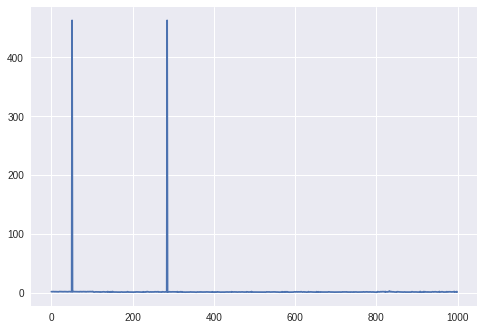

In [27]:
plt.plot(currents_no_labels[0])

In [28]:
# Skip some timesteps
skip = 1
currents_skip = list()
for currents in currents_no_labels:
  currents_skip.append(list())
  i = 0
  while True:
    currents_skip[-1].append(currents[i])
    i += skip
    if i >= len(currents):
      break

In [29]:
# Get training data into a numpy matrix
full_x = np.stack(currents_skip, axis=0)
# Get training labels
full_y = np.array([currents[1] for currents in currents_long])
full_y_labels = [from_one_hot(one_hot) for one_hot in full_y]

In [30]:
full_y_binary = [0 if label==categories_dict['cubes'] else 1 for label in full_y_labels]
full_x_norm = utils.normalize(full_x, axis=0, order=2)

[0. 0. 0. 0. 0. 1.]


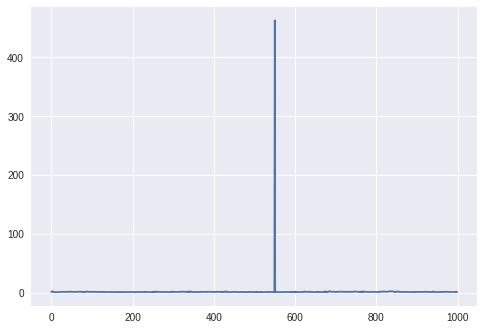

In [36]:
# Training set
#train_x = full_x_norm[10:89]
train_x = full_x[5:-5]
train_y = full_y_binary[5:-5]
# Test set
test_x = np.concatenate((full_x[:5], full_x[-5:]), axis=0)
test_y = full_y_binary[:5] + full_y_binary[-5:]

plt.plot(full_x[1])
print(full_y[1])

In [37]:
print(full_y_binary)
print(test_y)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


# Experiment

In [39]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1000, 64)          16896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000, 64)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [0]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', 'mse'])

In [0]:
history = model.fit(train_x, train_y, epochs = 100, batch_size=17, shuffle=True)

Epoch 1/100
33/33 [==============================] - 11s 330ms/step - loss: 0.6903 - acc: 0.4242
Epoch 2/100
33/33 [==============================] - 9s 261ms/step - loss: 0.6006 - acc: 0.7576
Epoch 3/100
33/33 [==============================] - 9s 268ms/step - loss: 0.5672 - acc: 0.7576
Epoch 4/100
33/33 [==============================] - 9s 264ms/step - loss: 0.5638 - acc: 0.7576
Epoch 5/100
33/33 [==============================] - 9s 264ms/step - loss: 0.5753 - acc: 0.7576
Epoch 6/100
33/33 [==============================] - 9s 263ms/step - loss: 0.5726 - acc: 0.7576
Epoch 7/100
33/33 [==============================] - 9s 263ms/step - loss: 0.5749 - acc: 0.7576
Epoch 8/100
33/33 [==============================] - 9s 264ms/step - loss: 0.5457 - acc: 0.7576
Epoch 9/100
33/33 [==============================] - 9s 265ms/step - loss: 0.5751 - acc: 0.7576
Epoch 10/100
33/33 [==============================] - 9s 264ms/step - loss: 0.5894 - acc: 0.7576
Epoch 11/100
33/33 [==================

Epoch 27/100
33/33 [==============================] - 9s 265ms/step - loss: 0.5434 - acc: 0.7879
Epoch 28/100
33/33 [==============================] - 9s 267ms/step - loss: 0.5349 - acc: 0.7879
Epoch 29/100
33/33 [==============================] - 9s 264ms/step - loss: 0.5234 - acc: 0.7879
Epoch 30/100
33/33 [==============================] - 9s 264ms/step - loss: 0.5401 - acc: 0.7879
Epoch 31/100
33/33 [==============================] - 9s 263ms/step - loss: 0.5199 - acc: 0.7879
Epoch 32/100
33/33 [==============================] - 9s 265ms/step - loss: 0.5004 - acc: 0.7879
Epoch 33/100
33/33 [==============================] - 9s 266ms/step - loss: 0.5372 - acc: 0.7879
Epoch 34/100
33/33 [==============================] - 9s 267ms/step - loss: 0.5643 - acc: 0.7879
Epoch 35/100
33/33 [==============================] - 9s 265ms/step - loss: 0.5191 - acc: 0.7879
Epoch 36/100
33/33 [==============================] - 9s 264ms/step - loss: 0.5265 - acc: 0.7879
Epoch 37/100
33/33 [==========

Epoch 53/100
33/33 [==============================] - 9s 269ms/step - loss: 0.5767 - acc: 0.7879
Epoch 54/100
33/33 [==============================] - 9s 264ms/step - loss: 0.5266 - acc: 0.7879
Epoch 55/100
33/33 [==============================] - 9s 264ms/step - loss: 0.5395 - acc: 0.7879
Epoch 56/100
33/33 [==============================] - 9s 263ms/step - loss: 0.5195 - acc: 0.7879
Epoch 57/100
33/33 [==============================] - 9s 262ms/step - loss: 0.5264 - acc: 0.7879
Epoch 58/100
33/33 [==============================] - 9s 265ms/step - loss: 0.5245 - acc: 0.7879
Epoch 59/100
33/33 [==============================] - 9s 267ms/step - loss: 0.5744 - acc: 0.7879
Epoch 60/100
33/33 [==============================] - 9s 271ms/step - loss: 0.5256 - acc: 0.7879
Epoch 61/100
33/33 [==============================] - 9s 272ms/step - loss: 0.5086 - acc: 0.7879
Epoch 62/100
33/33 [==============================] - 9s 269ms/step - loss: 0.5337 - acc: 0.7879
Epoch 63/100
33/33 [==========

Epoch 79/100
33/33 [==============================] - 9s 265ms/step - loss: 0.2277 - acc: 0.9394
Epoch 80/100
33/33 [==============================] - 9s 265ms/step - loss: 0.2315 - acc: 0.9394
Epoch 81/100
33/33 [==============================] - 9s 266ms/step - loss: 0.2266 - acc: 0.9394
Epoch 82/100
33/33 [==============================] - 9s 269ms/step - loss: 0.2214 - acc: 0.9394
Epoch 83/100
33/33 [==============================] - 9s 258ms/step - loss: 0.2000 - acc: 0.9394
Epoch 84/100
33/33 [==============================] - 8s 254ms/step - loss: 0.2304 - acc: 0.9394
Epoch 85/100
33/33 [==============================] - 9s 258ms/step - loss: 0.2073 - acc: 0.9394
Epoch 86/100
33/33 [==============================] - 9s 258ms/step - loss: 0.2384 - acc: 0.9394
Epoch 87/100
33/33 [==============================] - 9s 266ms/step - loss: 0.1843 - acc: 0.9394
Epoch 88/100
33/33 [==============================] - 9s 265ms/step - loss: 0.2226 - acc: 0.9394
Epoch 89/100
33/33 [==========

Text(0.5,0,'epoch')

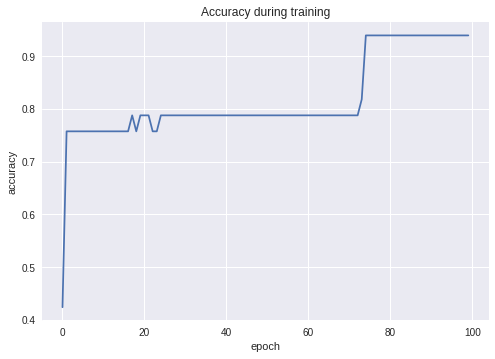

In [0]:
# Plot the accuracy during training
plt.plot(history.history['acc'])
plt.title("Accuracy during training")
plt.ylabel("accuracy")
plt.xlabel("epoch")

Text(0.5,0,'epoch')

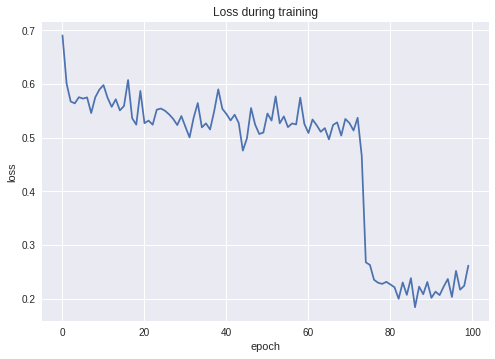

In [0]:
plt.plot(history.history['loss'])
plt.title("Loss during training")
plt.ylabel("loss")
plt.xlabel("epoch")

In [0]:
# Evalute the same model
model.evaluate(x=test_x, y=test_y)


10/10 [==============================] - 1s 100ms/step


[0.03714872524142265, 1.0]